## Eigenfaces

I got some help from [this sklearn page](https://scikit-learn.org/stable/auto_examples/applications/plot_face_recognition.html)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import SparsePCA
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

from PIL import Image
from io import BytesIO

%matplotlib inline

In [3]:
df = pd.read_csv("../data/train.csv")
df.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72


In [6]:
df.iloc[[67, 592, 2445, 2615, 3858, 8980, 9447, 9562, 11]]

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
67,01a4d7b6a0aec61f115ba3407ac3cb38,0,0,1,1,0,0,0,0,1,1,0,0,35
592,0f6c9f095d20a441f3bd3f9565462b80,0,1,1,1,0,0,0,0,0,0,0,0,31
2445,3edb6304228159af667deb11d12251fc,0,0,1,1,0,0,0,0,0,0,0,1,21
2615,4388dabf50790924baa7fec88b192b02,0,1,1,1,0,0,0,0,0,0,0,0,49
3858,624c731b8423dd9e2701de0b83aa4778,0,1,1,1,0,0,0,0,0,0,0,0,45
8980,e81d1e6711379eadd29a15cc6a4d4247,0,0,1,1,0,0,1,0,0,0,0,1,32
9447,f41f974df2735c0446b5720817bb3c6a,0,0,1,1,0,0,0,0,0,0,0,1,94
9562,f6df80db7cdb6e1901379311f0de2511,0,0,0,1,0,0,0,0,0,0,0,0,68
11,00524dbf2637a80cbc80f70d3ff59616,0,1,1,1,0,0,0,0,0,0,0,0,2


In [3]:
# I found in an earlier run that these images weren't resized properly. 
# No idea why, but I didn't have a chance to investigate.
baddies = [67, 592, 2445, 2615, 3858, 8980, 9447, 9562]
df = df.iloc[df.index.difference(baddies)]
df.index = np.arange(0, df.shape[0])
df.shape

(9904, 14)

In [4]:
target = df['Pawpularity']

In [5]:
images = df.apply(
    lambda t: np.asarray(Image.open(
        "../data/train_scaled_padded_black_and_white/" + t.Id + ".jpg")).reshape((1,47089)), axis=1)

In [6]:
images = np.concatenate(images)
images.shape

(9904, 47089)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(images, target, test_size=0.20, random_state=2)

In [8]:
X_train.shape

(7923, 47089)

In [77]:
model = PCA(n_components=5, svd_solver="randomized", whiten=True)
X_train_reduced = model.fit_transform(X_train)

In [78]:
ratios = pd.DataFrame(model.explained_variance_ratio_)
print(ratios[0:5])

          0
0  0.213855
1  0.165788
2  0.060343
3  0.055136
4  0.047479


In [79]:
X_test_reduced = model.transform(X_test)

In [81]:
eigenfaces = model.components_.reshape((20, 217, 217))

In [82]:
def plot_gallery(images, titles, h, w, n_row=5, n_col=7):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.90, hspace=0.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i - 1].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

IndexError: list index out of range

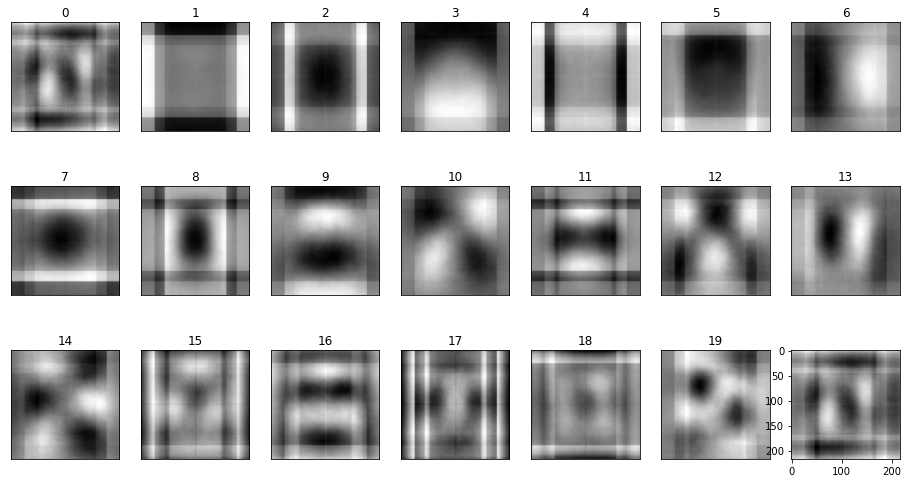

In [83]:
plot_gallery(eigenfaces, [str(i) for i in np.arange(0,20)], 217, 217)

In [84]:
mean = y_train.mean()

np.sqrt(mean_squared_error([mean for i in np.arange(0, y_test.shape[0])], y_test))

20.496740460826995

In [37]:
linearModel = LinearRegression()
linearModel.fit(X_train_reduced, y_train)
predictions = linearModel.predict(X_test_reduced)

print(np.sqrt(mean_squared_error(predictions, y_test)))
print(np.sqrt(mean_squared_error(linearModel.predict(X_train_reduced), y_train)))

20.507648717760134
20.59728261897821


In [75]:
NN_model = MLPClassifier(hidden_layer_sizes=(10, 10, 10), max_iter=1000)
NN_model.fit(X_train_reduced, y_train)
predictions = NN_model.predict(X_test_reduced)

print(np.sqrt(mean_squared_error(predictions, y_test)))
print(np.sqrt(mean_squared_error(NN_model.predict(X_train_reduced), y_train)))

33.697499221918626
31.455041953057147


In [85]:
svc = SVC(kernel='linear')
svc.fit(X_train_reduced, y_train)
predictions = svc.predict(X_test_reduced)

print(np.sqrt(mean_squared_error(predictions, y_test)))
print(np.sqrt(mean_squared_error(svc.predict(X_train_reduced), y_train)))

28.383354998826324
28.389570074354584


In [103]:
temp = pd.DataFrame([df.Pawpularity.unique(), df.Pawpularity.value_counts()]).transpose()

In [106]:
temp[temp[0] == 100]

,0,1
17,100,192


<BarContainer object of 100 artists>

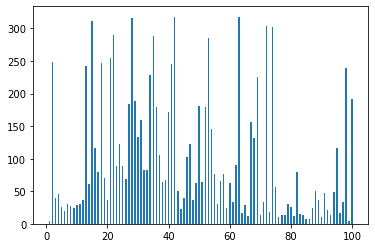

In [111]:
plt.bar(df.Pawpularity.unique(), df.Pawpularity.value_counts(), width = .5)

In [ ]:
plt